# QF5204: Assignment 1


### Fixed point

Q1. Implement a function that converts a ```fixed<w, b>``` representation to a real number. Use two's complement representation for negative numbers.

In [1]:
def from_fixed_point(w: int, b: int, bits: list[int]) -> float:
    assert len(bits) == w
    assert b <= w
    return sum((bits[-i-1] << i) for i in range(w - 1)) / (1 << b) - (bits[0] << (w - 1 - b))

In [2]:
assert from_fixed_point(10, 3, [0, 1, 0, 1, 1, 0, 0, 1, 1, 0]) == 44.75
assert from_fixed_point(10, 5, [1, 0, 0, 1, 0, 1, 0, 1, 1, 1]) == -13.28125
assert from_fixed_point(8, 2, [1, 0, 1, 0, 1, 0, 1, 1]) == -21.25

### CRR Binomial Tree

Q2. Manually calculate the prices of the following options step by step using two-step Cox Rox Rubinstein (CRR) Binomial tree.

a. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$  
b. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 20%$  
c. European call option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$  
d. European put option with $S = 100$, $K = 105$, $r = 3%$, $T=1$, $\sigma = 10%$  

What is the value of the portfolio that is long (a) and short (b)? How about the portfolio that long (c) and short (d)?

In [3]:
import math

def crrCalib(r, vol, t):
    b = math.exp((r + vol*vol) * t) + math.exp(-r*t)
    u = (b + math.sqrt(b*b - 4)) / 2
    p = (u*math.exp(r*t) - 1) / (u*u - 1) if u != 1 else 1/2
    return (u, 1/u, p)

```
                      /----- S[2, 0]

        /---- S[1, 0] 

S[0, 0]               |----- S[2, 1]

        \---- S[1, 1] 

                      \----- S[2, 2]
```

In [4]:
t = 1/2
S, K, D = 100, 105, math.exp(-0.03 * t)

Compute spot prices at second (last) step.

In [5]:
u, d, p = crrCalib(0.03, 0.2, t)

S20 = u*u*S
S21 = S
S22 = d*d*S

Value at last step is just the payoff. Value at intermediate steps is a combination of the values from the next step. Compute value from right to left.

a. Call option, vol=0.2

In [6]:
V20 = max(S20 - K, 0)
V21 = max(S21 - K, 0)
V22 = max(S22 - K, 0)

V10 = D * (p*V20 + (1 - p)*V21)
V11 = D * (p*V21 + (1 - p)*V22)

V00 = D * (p*V10 + (1 - p)*V11)
print(V00)

7.334893644624996


b. Put option, vol=0.2

In [7]:
V20 = max(K - S20, 0)
V21 = max(K - S21, 0)
V22 = max(K - S22, 0)

V10 = D * (p*V20 + (1 - p)*V21)
V11 = D * (p*V21 + (1 - p)*V22)

V00 = D * (p*V10 + (1 - p)*V11)
print(V00)

9.231674667218375


Repeat, but with volatility 0.1

In [8]:
u, d, p = crrCalib(0.03, 0.1, t)

S20 = u*u*S
S21 = S
S22 = d*d*S

c. Call option, vol=0.1

In [9]:
V20 = max(S20 - K, 0)
V21 = max(S21 - K, 0)
V22 = max(S22 - K, 0)

V10 = D * (p*V20 + (1 - p)*V21)
V11 = D * (p*V21 + (1 - p)*V22)

V00 = D * (p*V10 + (1 - p)*V11)
print(V00)

3.555283800757028


d. Put option, vol=0.1

In [10]:
V20 = max(K - S20, 0)
V21 = max(K - S21, 0)
V22 = max(K - S22, 0)

V10 = D * (p*V20 + (1 - p)*V21)
V11 = D * (p*V21 + (1 - p)*V22)

V00 = D * (p*V10 + (1 - p)*V11)
print(V00)

5.452064823350389


The value of a portfolio that is long on call and short on put is P - C. From put-call parity, P - C = KD - S. Since it doesn't depend on volatility, both portfolios will have the same value:

In [11]:
5.452065 - 3.555283, 9.231575 - 7.334893, K*math.exp(-0.03 * 1) - S

(1.896782, 1.8966819999999993, 1.896781022593359)

### Greeks

Q3. Greeks measure the sensitivity of the price of derivatives to a change in underlying asset’s parameters. They are used for hedging and risk management. The commonly used greeks (risk sensitivities) are:

* Delta: $\Delta = \frac{\partial V}{\partial S}$: measures the rate of change of the option value with respect to changes in the underlying asset's price.
* Gamma: $\Gamma = \frac{\partial^2 V}{\partial S^2} = \frac{\partial \Delta}{\partial S}$: measures the rate of change of delta with respect to changes in the underlying asset's price.
* Vega: $v = \frac{\partial V}{\partial \sigma}$: measures the rate of change of the option value with respect to changes in the underlying asset's volatility.
* Theta: $\theta = \frac{\partial V}{\partial t}$: the rate of change in the price of an option with respect to pricing time. Note that we normally use $t$ to represent pricing time, $T$ to represent expiry time, time to expiry in our pricer is $T-t$. In the implementation of the pricers that take time to expiry as an argument, we implicitly set pricing time to 0 (present).
* Rho: the rate of change in the price of an option in response to a change in the interest rate.

The greeks are normally not known in closed form since numerical pricers are used. They are approximated by finite differences:

$$
\begin{align}
& \Delta = \frac{\partial V}{\partial S} \approx \frac{V(S + \Delta S) - V(S-\Delta S)}{2 \Delta S}, ~~~\Delta S = 0.1\% S \\
& \Gamma = \frac{\partial V^2}{\partial S^2} \approx \frac{V(S + \Delta S) - 2V(S) + V(S-\Delta S)}{\Delta S^2} \\
& v = \frac{\partial V}{\partial \sigma} \approx \frac{V(S, \sigma +\Delta \sigma) - V(S, \sigma -\Delta \sigma)}{2 \Delta \sigma } ~~~~~~~\Delta \sigma = 0.1\% \\
& \theta = \frac{\partial V}{\partial t} \approx \frac{V(S, t+\Delta t, T) - V(S, t, T)}{\Delta t} ~~~~\Delta t = 0.004 \\
& \rho = \frac{\partial V}{\partial r} \approx \frac{V(S, r+\Delta r) - V(S, r - \Delta r)}{2 \Delta r}  ~~~~~\Delta r = 0.0001
\end{align}
$$

Implement a Greeks calculater for binomial tree pricer provided below. The signature of the greeks calculator is
```python
def binomialGreeks(S, r, vol, T, strike, greekType) -> float
```
      
  Setting $S = 100, r = 0.03, vol = 0.2$, plot each greeks as a function of strike for 1 year European call option with strike from 50 to 150. Play with different binomial models and see if there is any difference.
  
  Note that in practice, the greeks are rescaled with a pre-defined scaler, so that they give a sense of how much PV (Delta) changes with a typical move of the market. The rescaling is not incorporated in this exercise.

Some basic classes to hold our data.

In [12]:
import datetime
from enum import Enum


class PayoffType(Enum):
    CALL = 1
    PUT = 2


class Stock:
    def __init__(self, ticker: str, spot_price: float):
        self.ticker = ticker
        self.spot_price = spot_price


class Option:
    def __init__(self,
                 payoff_type: PayoffType,
                 underlying: Stock,
                 strike_price: float,
                 expiration_date: datetime.date):
        self.payoff_type = payoff_type

        self.underlying = underlying

        self.strike_price = strike_price
        self.expiration_date = expiration_date

    def is_call(self) -> bool:
        return self.payoff_type == PayoffType.CALL

    def is_put(self) -> bool:
        return not self.is_call()

    def _payoff(self, spot_price: float) -> float:
        if self.is_call():
            return max(spot_price - self.strike_price, 0)
        return max(self.strike_price - spot_price, 0)

    def payoff(self, spot_price: float, time_to_maturity: float = 0) -> float:
        raise NotImplementedError()


class EuropeanOption(Option):
    def payoff(self, spot_price: float, time_to_maturity: float = 0) -> float:
        return super()._payoff(spot_price) if math.isclose(time_to_maturity, 0, abs_tol=1e-6) else 0


class AmericanOption(Option):
    def payoff(self, spot_price: float, time_to_maturity: float = 0) -> float:
        return super()._payoff(spot_price)

Now we write functions to compute greeks. The idea is to compute option value twice with all the same inputs except the one that defines the greek.

In [13]:
import copy
from typing import Callable


class GreekType(Enum):
    DELTA = 1
    GAMMA = 2
    THETA = 3
    VEGA = 4
    RHO = 5


def binomial_greeks(pricer: Callable,
                    option: Option,
                    greek_type: GreekType,
                    **kwargs) -> float:

    def compute_delta(finite_difference_ratio: float = 0.001) -> float:
        finite_difference = finite_difference_ratio * option.underlying.spot_price

        up = copy.deepcopy(option)
        up.underlying.spot_price += finite_difference
        high = pricer(up, **kwargs)

        down = copy.deepcopy(option)
        down.underlying.spot_price -= finite_difference
        low = pricer(down, **kwargs)

        return (high - low) / (2 * finite_difference)

    def compute_gamma(finite_difference_ratio: float = 0.001) -> float:
        finite_difference = finite_difference_ratio * option.underlying.spot_price

        same = pricer(option, **kwargs)

        up = copy.deepcopy(option)
        up.underlying.spot_price += finite_difference
        high = pricer(up, **kwargs)

        down = copy.deepcopy(option)
        down.underlying.spot_price -= finite_difference
        low = pricer(down, **kwargs)

        return (high - 2*same + low) / (finite_difference * finite_difference)

    def compute_theta(finite_difference: float = 0.004) -> float:
        now = pricer(option, **kwargs)

        kwargs["time_to_maturity"] -= finite_difference
        later = pricer(option, **kwargs)

        return (later - now) / finite_difference

    def compute_rho(finite_difference: float = 0.0001) -> float:
        kwargs["risk_free_rate"] +=  finite_difference
        high = pricer(option, **kwargs) 

        kwargs["risk_free_rate"] -= 2 * finite_difference
        low = pricer(option, **kwargs)

        return (high - low) / (2 * finite_difference)

    def compute_vega(finite_difference_ratio: float = 0.001) -> float:
        finite_difference = finite_difference_ratio * kwargs["vol"]

        kwargs["vol"] += finite_difference
        high = pricer(option, **kwargs)

        kwargs["vol"] -= 2 * finite_difference
        low = pricer(option, **kwargs)

        return (high - low) / (2 * finite_difference)

    if greek_type == GreekType.DELTA:
        return compute_delta()
    if greek_type == GreekType.GAMMA:
        return compute_gamma()
    if greek_type == GreekType.THETA:
        return compute_theta()
    if greek_type == GreekType.VEGA:
        return compute_vega() / 100
    if greek_type == GreekType.RHO:
        return compute_rho() / 100

    assert False, "Unknown greek type"

Oki, now we write the binomial pricer and several calibrators

In [14]:
def jrrnCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)

def jreqCalib(r, vol, t):
    u = math.exp((r - vol * vol / 2) * t + vol * math.sqrt(t))
    d = math.exp((r - vol * vol / 2) * t - vol * math.sqrt(t))
    return (u, d, 1/2)

def tianCalib(r, vol, t):
    v = math.exp(vol * vol * t)
    u = 0.5 * math.exp(r * t) * v * (v + 1 + math.sqrt(v*v + 2*v - 3))
    d = 0.5 * math.exp(r * t) * v * (v + 1 - math.sqrt(v*v + 2*v - 3))
    p = (math.exp(r * t) - d) / (u - d)
    return (u, d, p)


def binomial_pricer(option: Option,
                    risk_free_rate: float,
                    vol: float,
                    time_to_maturity: float,
                    calibrator: Callable = crrCalib,
                    num_steps: int = 100):

    r = risk_free_rate
    t = time_to_maturity / num_steps
    (u, d, p) = calibrator(r, vol, t)

    S = option.underlying.spot_price
    value = [option.payoff(S * (u ** (num_steps - i)) * (d ** i)) for i in range(num_steps + 1)]

    discount_factor = math.exp(-r*t)
    for i in range(num_steps - 1, -1, -1):
        for j in range(i + 1):
            current_time_to_maturity = time_to_maturity - i*t

            current_payoff = option.payoff((u ** (i - j)) * (d ** j) * S, current_time_to_maturity)
            expected_payoff_upon_continuation = discount_factor * (p*value[j] + (1 - p)*value[j + 1])

            # Note: for European options, current_payoff is 0
            value[j] = max(current_payoff, expected_payoff_upon_continuation)

    return round(value[0], 4)

In [15]:
print(binomial_pricer(EuropeanOption(PayoffType.CALL, Stock("AAPL", 100), 105, datetime.date.today()), 0.03, 0.2, 1, num_steps=2))
print(binomial_pricer(EuropeanOption(PayoffType.PUT, Stock("AAPL", 100), 105, datetime.date.today()), 0.03, 0.2, 1, num_steps=2))
print(binomial_pricer(EuropeanOption(PayoffType.CALL, Stock("AAPL", 100), 105, datetime.date.today()), 0.03, 0.1, 1, num_steps=2))
print(binomial_pricer(EuropeanOption(PayoffType.PUT, Stock("AAPL", 100), 105, datetime.date.today()), 0.03, 0.1, 1, num_steps=2))

7.3349
9.2317
3.5553
5.4521


Now that we have the pricer and the greek calculator, we are ready to plot the greeks vs spot price

In [16]:
import numpy as np


def build_option_range(option_style: Option,
                       payoff_type: PayoffType,
                       strike_price_range: np.ndarray,
                       spot_price: float = 100) -> list[Option]:
    return [
        option_style(
            payoff_type=payoff_type,
            underlying=Stock(ticker="TEST", spot_price=spot_price),
            strike_price=strike_price,
            expiration_date=datetime.date.today() + datetime.timedelta(days=365)
        )
        for strike_price in strike_price_range
    ]

In [17]:
import matplotlib.pyplot as plt


def plot(xval, yval, xlabel, ylabel, title):
    plt.plot(xval, yval)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


def plot_greeks(pricer: Callable,
                options: list[Option],
                greek_type: GreekType,
                krange: np.ndarray,
                risk_free_rate: float = 0.03,
                time_to_maturity: float = 1,
                vol: float = 0.2,
                **kwargs):
    greek = [
        binomial_greeks(
            binomial_pricer,
            option,
            greek_type=greek_type,
            risk_free_rate=risk_free_rate,
            time_to_maturity=time_to_maturity,
            vol=vol,
            **kwargs
        )
        for option in options
    ]
    plot(krange, greek, "K", f"{greek_type}", f"European Call: {greek_type} vs Strike")

In [18]:
strike_price_range = np.arange(50, 150, 5)

options = build_option_range(
    option_style=EuropeanOption,
    payoff_type=PayoffType.CALL,
    strike_price_range=strike_price_range,
    spot_price=100
)

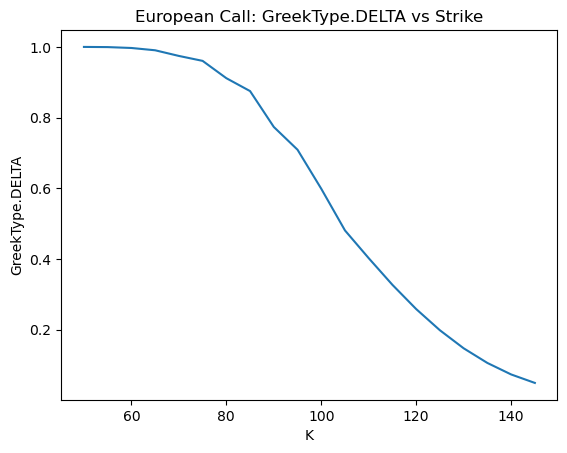

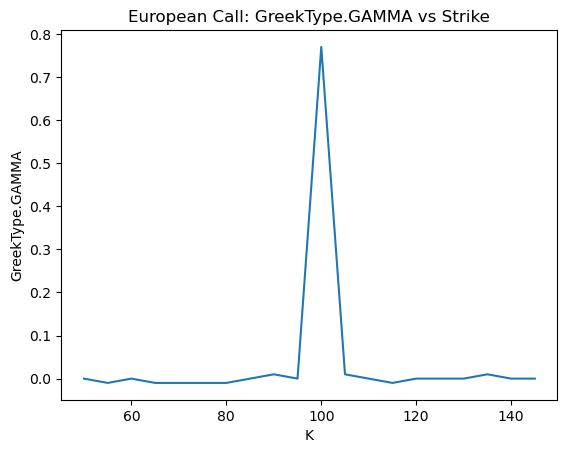

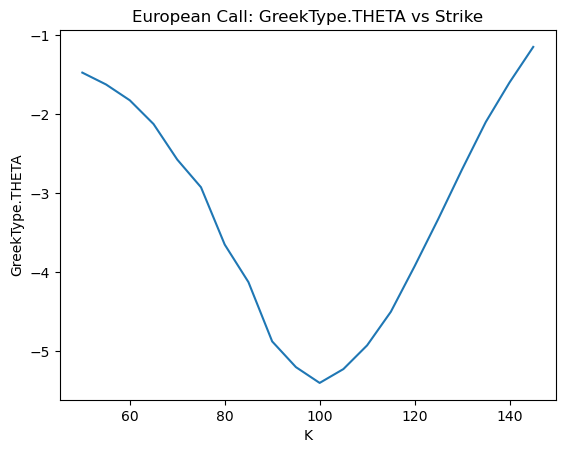

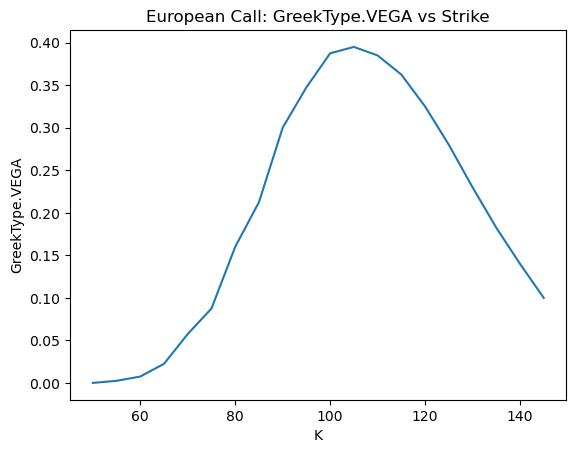

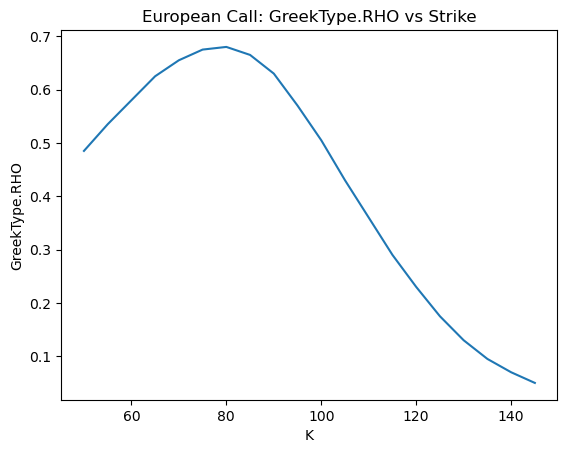

In [19]:
for greek_type in GreekType:
    plot_greeks(binomial_pricer, options, greek_type, strike_price_range)

Let's try the Tian's calibrator.

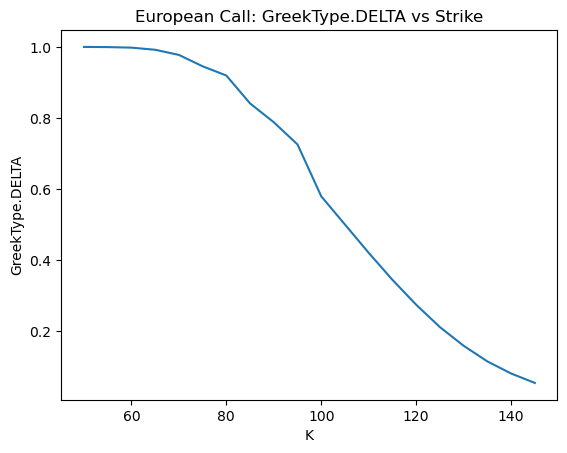

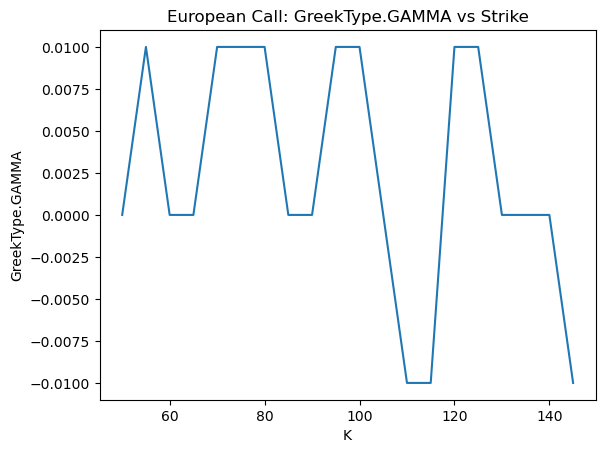

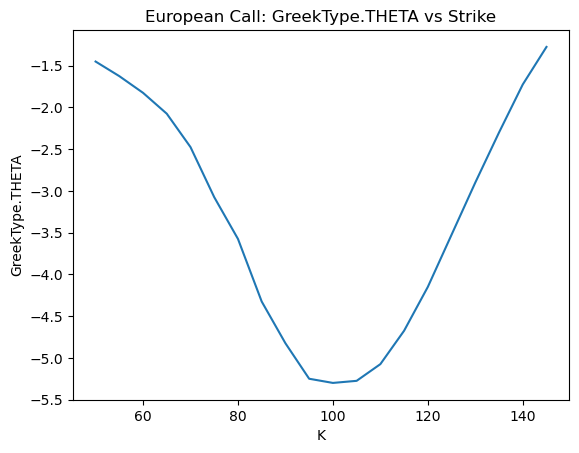

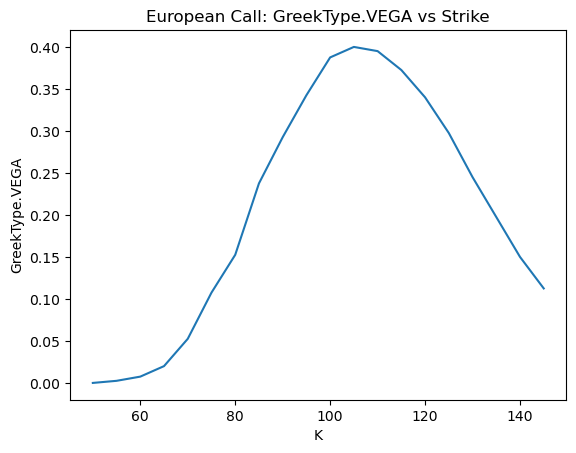

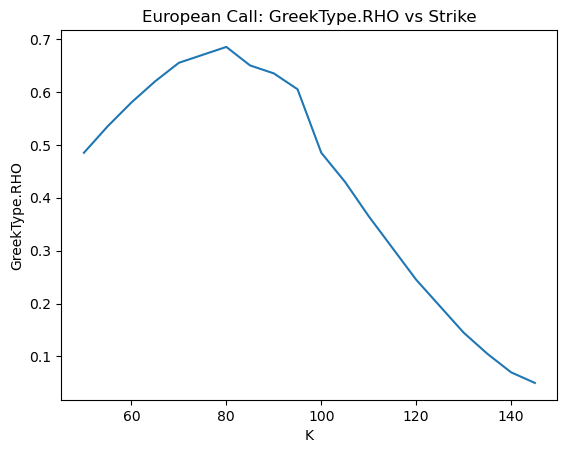

In [20]:
for greek_type in GreekType:
    plot_greeks(binomial_pricer, options, greek_type, strike_price_range, calibrator=tianCalib)

All the plots look similar except gamma. Let's try gamma for all calibrators.

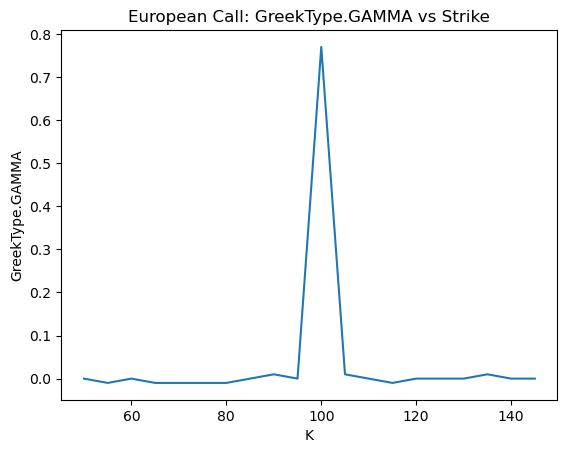

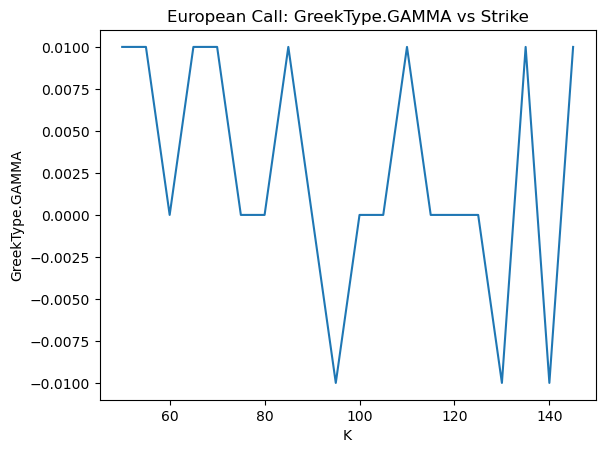

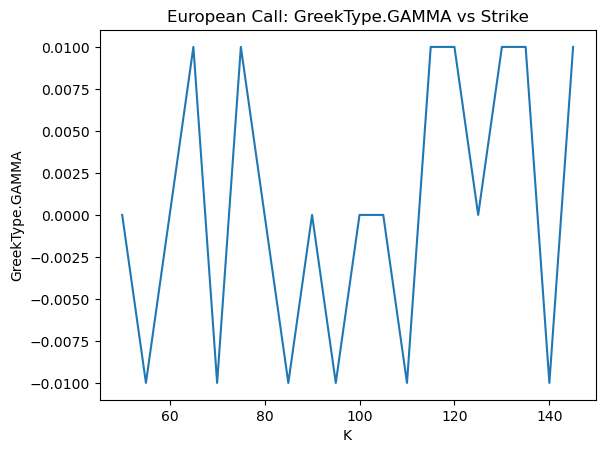

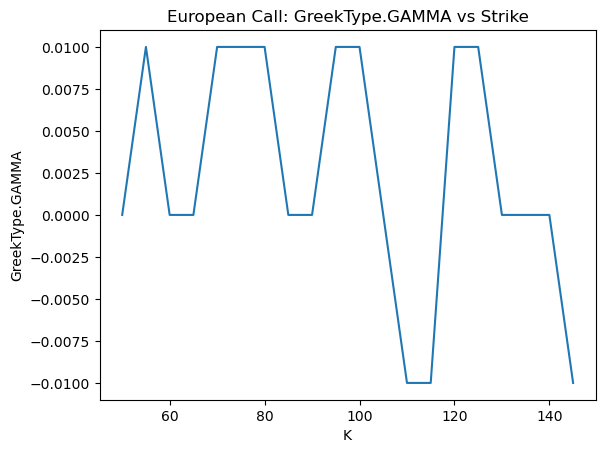

In [21]:
for calibrator in [crrCalib, jreqCalib, jrrnCalib, tianCalib]:
    plot_greeks(binomial_pricer, options, GreekType.GAMMA, strike_price_range, calibrator=calibrator)

Weird. Let's try more price points.

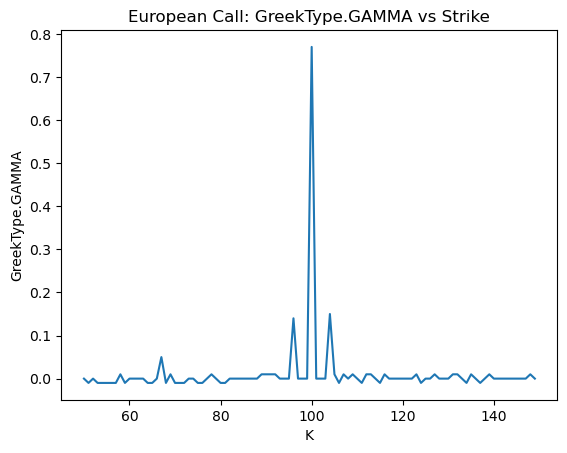

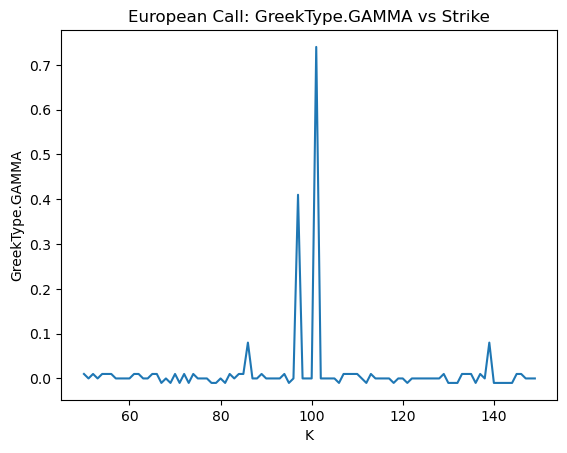

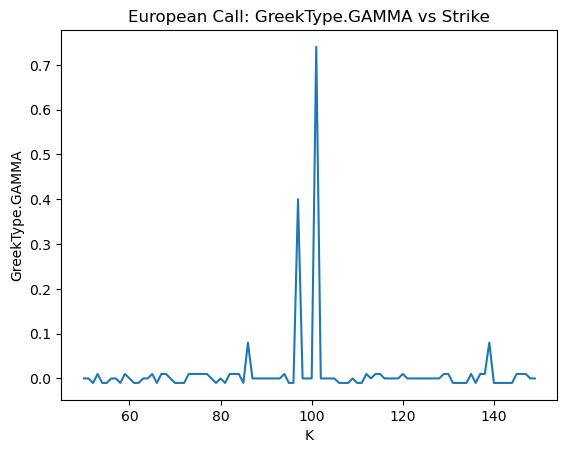

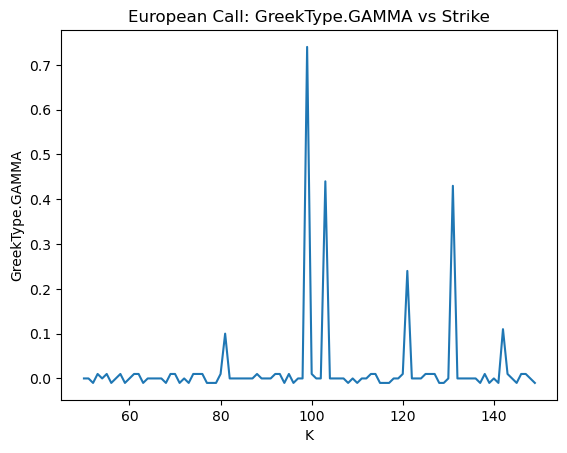

In [22]:
strike_price_range = np.arange(50, 150, 1)

options = build_option_range(
    option_style=EuropeanOption,
    payoff_type=PayoffType.CALL,
    strike_price_range=strike_price_range,
    spot_price=100
)

for calibrator in [crrCalib, jreqCalib, jrrnCalib, tianCalib]:
    plot_greeks(binomial_pricer, options, GreekType.GAMMA, strike_price_range, calibrator=calibrator)

There are some spikes that are not at 100, but otherwise, the plots seem to match. It's understandable to have random spikes as we are computing discretely.